# Getting Started with Minerva for Human Activity Recognition

Human Activity Recognition (HAR) is a challenging task that involves identifying actions performed by individuals based on sensor data—typically time-series signals from accelerometers and gyroscopes.

In this notebook, we will use Minerva to train and evaluate an [1D ResNet-SE](https://ieeexplore.ieee.org/document/9771436) model from scratch for classifying human activities using [DAGHAR Dataset](https://www.nature.com/articles/s41597-024-03951-4).

Thus, this notebook is a step-by-step guide to get you started with Minerva for HAR.
It comprehends the following steps:

1. Data Preparation
2. Model Creation
3. Model Training
4. Model Evaluation

## Imports

In [1]:
from pathlib import Path

import lightning as L
import matplotlib.pyplot as plt
import torch
from torchmetrics import Accuracy

from minerva.data.readers.csv_reader import CSVReader
from minerva.data.datasets.base import SimpleDataset
from minerva.data.data_modules.base import MinervaDataModule
from minerva.models.nets.time_series.resnet import ResNetSE1D_5
from minerva.transforms import Reshape, CastTo, TransformPipeline

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Data Preparation

We begin by preparing the data required for training and evaluation.

For this tutorial, we will use the [standardized view of the DAGHAR Dataset](https://zenodo.org/records/13987073), as introduced in the following paper:

```latex
Napoli, O., Duarte, D., Alves, P., Soto, D.H.P., de Oliveira, H.E., Rocha, A., Boccato, L. and Borin, E., 2024. 
A benchmark for domain adaptation and generalization in smartphone-based human activity recognition. 
Scientific Data, 11(1), p.1192.
```

This dataset includes time-series data from two tri-axial sensors—an accelerometer and a gyroscope—collected via smartphones. It is organized into six different datasets:
- KuHar  
- MotionSense  
- RealWorld-waist  
- RealWorld-thigh  
- UCI  
- WISDM  

In this notebook, we will work with the **standardized view of the MotionSense** dataset.

You can download and extract the dataset using the commands below (`wget` and `unzip`):

In [ ]:
!wget https://zenodo.org/records/13987073/files/standardized_view.zip?download=1 -O daghar_standardized_view.zip
!mkdir -p datasets/DAGHAR
!unzip -o daghar_standardized_view.zip -d datasets/DAGHAR/
!rm daghar_standardized_view.zip


Once extracted, the folder structure will look like this:

```tree
daghar_standardized_view/standardized_view
├── KuHar
│   ├── train.csv
│   ├── test.csv
│   └── val.csv
├── MotionSense
│   ├── train.csv
│   ├── test.csv
│   └── val.csv
├── RealWorld_waist
│   ├── train.csv
│   ├── test.csv
│   └── val.csv
├── RealWorld_thigh
│   ├── train.csv
│   ├── test.csv
│   └── val.csv
├── UCI
│   ├── train.csv
│   ├── test.csv
│   └── val.csv
└── WISDM
    ├── train.csv
    ├── test.csv
    └── val.csv
```

Each dataset is split into `train.csv`, `val.csv`, and `test.csv` files. Each file contains time-series data with the following structure:

| Column Range                  | Description                                 | Pattern to match            |
|-------------------------------|---------------------------------------------|-----------------------------|
| `accel-x-0` to `accel-x-59`   | 60 time steps of accelerometer x-axis       | `accel-x-*`                 |
| `accel-y-0` to `accel-y-59`   | 60 time steps of accelerometer y-axis       | `accel-y-*`                 |
| `accel-z-0` to `accel-z-59`   | 60 time steps of accelerometer z-axis       | `accel-z-*`                 |
| `gyro-x-0` to `gyro-x-59`     | 60 time steps of gyroscope x-axis           | `gyro-x-*`                  |
| `gyro-y-0` to `gyro-y-59`     | 60 time steps of gyroscope y-axis           | `gyro-y-*`                  |
| `gyro-z-0` to `gyro-z-59`     | 60 time steps of gyroscope z-axis           | `gyro-z-*`                  |
| `standard activity code`      | Encoded activity label                      | `standard activity code`    |

Each row represents one sample, composed of 6 channels (3 from each sensor) and 60 time steps per channel, representing 3 seconds of data at a sampling rate of 20 Hz.
The "Pattern to match" column indicates the regex pattern used to identify the columns in the dataset.

All datasets in DAGHAR share the same structure and label set. The activity codes are mapped as follows:

| Standard Activity Code | Activity     |
|------------------------|--------------|
| 0                      | Sit          |
| 1                      | Stand        |
| 2                      | Walk         |
| 3                      | Stair-up     |
| 4                      | Stair-down   |
| 5                      | Run          |


### 1.1. Creating Data Readers and Datasets

In Minerva, we can create readers, which are responsible for loading a single unit of data in a ordered way. It is like an ordered iterator that loads data from a source. A dataset is a collection of readers and transforms associated to each reader.
We will create two readers for each split of the dataset (train, validation, and test): the data reader and label reader. For this purpose, we will use `CSVReader` that loads data from CSV files, select the columns that match the regex patterns, and reshape it to a format suitable for training.

The data reader requires the following parameters:
- `path`: Path to the CSV file.
- `columns_to_select`: A list of regular expressions to select the columns from the CSV file, in order. In our case, we will use patterns indicated in the table above. Thus, we will select the columns that match the regex patterns `accel-x-*`, `accel-y-*`, `accel-z-*`, `gyro-x-*`, `gyro-y-*`, and `gyro-z-*`. This will give us a total of 360 columns (60 time steps * 6 channels), in order of pattern matched:
  - `accel-x-*`: 60 columns (`accel-x-0` to `accel-x-59`)
  - `accel-y-*`: 60 columns (`accel-y-0` to `accel-y-59`)
  - `accel-z-*`: 60 columns (`accel-z-0` to `accel-z-59`)
  - `gyro-x-*`: 60 columns  (`gyro-x-0` to `gyro-x-59`)
  - `gyro-y-*`: 60 columns  (`gyro-y-0` to `gyro-y-59`)
  - `gyro-z-*`: 60 columns  (`gyro-z-0` to `gyro-z-59`)

The label reader requires the following parameters:
- `path`: Path to the CSV file.
- `columns_to_select`: A single string indicating the column name to select. In our case, we will use `standard activity code`, which is the name of the column that contains the activity labels.
- `cast_to`: The data type of the labels. In our case, we will use `np.int64`, which is a 64-bit integer. 


In [3]:
# train_reader
root_data_dir = Path("datasets/DAGHAR/standardized_view/MotionSense/")

# Train data and label readers
train_data_reader = CSVReader(
    path=root_data_dir / "train.csv",
    columns_to_select=[
        "accel-x-*",
        "accel-y-*",
        "accel-z-*",
        "gyro-x-*",
        "gyro-y-*",
        "gyro-z-*",
    ],
)
train_label_reader = CSVReader(
    path=root_data_dir / "train.csv",
    columns_to_select="standard activity code",
    cast_to="int64",
)

# Validation data and label readers
validation_data_reader = CSVReader(
    path=root_data_dir / "validation.csv",
    columns_to_select=[
        "accel-x-*",
        "accel-y-*",
        "accel-z-*",
        "gyro-x-*",
        "gyro-y-*",
        "gyro-z-*",
    ],
)
validation_label_reader = CSVReader(
    path=root_data_dir / "validation.csv",
    columns_to_select="standard activity code",
    cast_to="int64",
)

# Test data and label readers
test_data_reader = CSVReader(
    path=root_data_dir / "test.csv",
    columns_to_select=[
        "accel-x-*",
        "accel-y-*",
        "accel-z-*",
        "gyro-x-*",
        "gyro-y-*",
        "gyro-z-*",
    ],
)
test_label_reader = CSVReader(
    path=root_data_dir / "test.csv",
    columns_to_select="standard activity code",
    cast_to="int64",
)

print(
    f"Train data reader length: {len(train_data_reader)}; Label reader length: {len(train_label_reader)}"
)
print(
    f"Validation data reader length: {len(validation_data_reader)}; Label reader length: {len(validation_label_reader)}"
)
print(
    f"Test data reader length: {len(test_data_reader)}; Label reader length: {len(test_label_reader)}"
)

Train data reader length: 3558; Label reader length: 3558
Validation data reader length: 420; Label reader length: 420
Test data reader length: 1062; Label reader length: 1062


Once the readers are set up, we can create a dataset using them. For this purpose, we'll use the `SimpleDataset` class, which takes two main inputs:

- A list of **readers** (data sources)  
- A list of **transforms** (optional preprocessing steps)

When an item at index `i` is requested from the dataset (e.g., `dataset[i]`), the following steps occur:

1. The dataset retrieves the item at index `i` from `reader[0]` and applies the corresponding transform `transform[0]` (if any).
2. It then retrieves the item at index `i` from `reader[1]` and applies `transform[1]` (if any).
3. Finally, it returns a 2-element tuple containing the transformed outputs:
   - The first element is data: `transform[0](reader[0][i])`
   - The second element is label: `transform[1](reader[1][i])`

This design enables flexible and consistent pairing of multiple data sources with their corresponding preprocessing logic-ideal for training, validation, or testing workflows.


As transformation, we will use `Reshape` to reshape the data to the format required by the model, in our case `(6, 60)`, which means 6 channels (3 from each sensor) and 60 time steps per channel. We also use a `CastTo` transform to cast the data to `np.float32`, which is the data type required by the model and labels to `np.int64`.

In [4]:
train_dataset = SimpleDataset(
    readers=[
        train_data_reader,  # Reader for the data
        train_label_reader,  # Reader for the labels
    ],
    transforms=[
        TransformPipeline(
            [Reshape((6, 60)), CastTo("float32")]
        ),  # Transforms to apply to the data
        CastTo("int64"),  # Cast the labels to int64
    ],
)

val_dataset = SimpleDataset(
    readers=[validation_data_reader, validation_label_reader],
    transforms=[
        TransformPipeline(
            [Reshape((6, 60)), CastTo("float32")]
        ),  # Transforms to apply to the data
        CastTo("int64"),  # Cast the labels to int64
    ],
)

test_dataset = SimpleDataset(
    readers=[test_data_reader, test_label_reader],
    transforms=[
        TransformPipeline(
            [Reshape((6, 60)), CastTo("float32")]
        ),  # Transforms to apply to the data
        CastTo("int64"),  # Cast the labels to int64
    ],
)

In [5]:
print(f"Train dataset\n {train_dataset}\n")
print(f"Validation dataset\n {val_dataset}\n")
print(f"Test dataset\n {test_dataset}\n")

Train dataset
           📂 SimpleDataset Information            
📌 Dataset Type: SimpleDataset
   └── Reader 0: TabularReader(df=(3558, 728), columns_to_select=['accel-x-*', 'accel-y-*', 'accel-z-*', 'gyro-x-*', 'gyro-y-*', 'gyro-z-*'], cast_to=None, data_shape=None)
   │     └── Transform: TransformPipeline(transforms=[Reshape(shape=(6, 60)), CastTo(dtype=float32)])
   └── Reader 1: TabularReader(df=(3558, 728), columns_to_select=['standard activity code'], cast_to=int64, data_shape=None)
   │     └── Transform: CastTo(dtype=int64)
   │
   └── Total Readers: 2

Validation dataset
           📂 SimpleDataset Information            
📌 Dataset Type: SimpleDataset
   └── Reader 0: TabularReader(df=(420, 728), columns_to_select=['accel-x-*', 'accel-y-*', 'accel-z-*', 'gyro-x-*', 'gyro-y-*', 'gyro-z-*'], cast_to=None, data_shape=None)
   │     └── Transform: TransformPipeline(transforms=[Reshape(shape=(6, 60)), CastTo(dtype=float32)])
   └── Reader 1: TabularReader(df=(420, 728), columns_to_

Let's take a look at the first sample of the training dataset. 
As each sample has 6 channels and 60 time steps, the shape of the sample will be `(6, 60)`.
The label will be a single integer representing the activity code.
We can visualize the data using `matplotlib` to get an idea of what the data looks like.

The shape of the input is (6, 60) and the label is 5


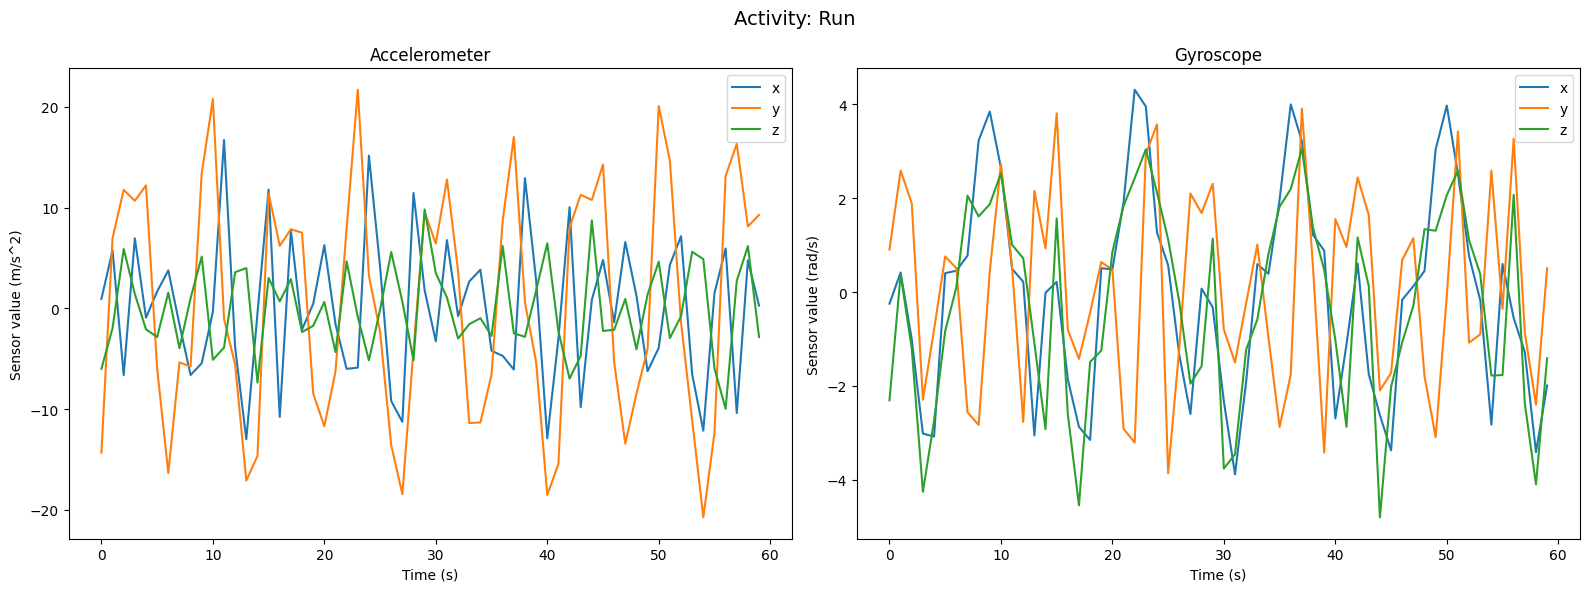

In [6]:
sample_X, sample_y = train_dataset[800]
print(f"The shape of the input is {sample_X.shape} and the label is {sample_y}")

activity_labels = {
    0: "Sit",
    1: "Stand",
    2: "Walk",
    3: "Stair-up",
    4: "Stair-down",
    5: "Run",
}

activity = activity_labels[sample_y]

fig = plt.figure(figsize=(16, 6))
fig.suptitle(f"Activity: {activity}", fontsize=14)
# Accelerometer subplot
plt.subplot(1, 2, 1)
# plt.subptitle(f"Activity: {activity}")
plt.plot(sample_X[0, :], label="x")
plt.plot(sample_X[1, :], label="y")
plt.plot(sample_X[2, :], label="z")
plt.title(f"Accelerometer")
plt.xlabel("Time (s)")
plt.ylabel("Sensor value (m/s^2)")
plt.legend()

# Gyroscope subplot
plt.subplot(1, 2, 2)
plt.plot(sample_X[3, :], label="x")
plt.plot(sample_X[4, :], label="y")
plt.plot(sample_X[5, :], label="z")
plt.title(f"Gyroscope")
plt.xlabel("Time (s)")
plt.ylabel("Sensor value (rad/s)")
plt.legend()

plt.tight_layout()
plt.show()

### 1.2. Creating the `MinervaDataModule`

Minerva models are implemented using Pytorch Lightning. 
Thus, to train a model we should create a `LightningDataModule` object that will handle the data loading and preprocessing.
Minerva provides a `MinervaDataModule` class that extends Pytorch Lightning's `LightningDataModule` class and standardizes the data loading process.

We may create a `MinervaDataModule` object by passing the training, validation, and testing datasets, as well as the batch size and the number of workers for data loading

In [7]:
data_module = MinervaDataModule(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    batch_size=64,
    name="MotionSense Dataset",
    num_workers=4,
)

print(data_module)

               🆔 MotionSense Dataset
└── Predict Split: test
📂 Datasets:
   ├── Train Dataset:
   │      ==================================================
   │                 📂 SimpleDataset Information            
   │      ==================================================
   │      📌 Dataset Type: SimpleDataset
   │         └── Reader 0: TabularReader(df=(3558, 728), columns_to_select=['accel-x-*', 'accel-y-*', 'accel-z-*', 'gyro-x-*', 'gyro-y-*', 'gyro-z-*'], cast_to=None, data_shape=None)
   │         │     └── Transform: TransformPipeline(transforms=[Reshape(shape=(6, 60)), CastTo(dtype=float32)])
   │         └── Reader 1: TabularReader(df=(3558, 728), columns_to_select=['standard activity code'], cast_to=int64, data_shape=None)
   │         │     └── Transform: CastTo(dtype=int64)
   │         │
   │         └── Total Readers: 2
   │      ==================================================
   ├── Val Dataset:
   │      ==================================================
   │   

## 2. Creating the Model

Minerva provides several models to be used in Human Activity Recognition. 
In this notebook we will use the [`ResNetSE1D_5` model](https://ieeexplore.ieee.org/document/9771436) which is a 1D ResNet model with Squeeze-and-Excitation blocks and 5 residual blocks.

To create the model, we just need to call the `ResNetSE1D_5` class from Minerva and pass the following parameters:
- `input_shape`: Shape of each input samples, in the format `(channels, time_steps)`. In this case, it will be `(6, 60)`.
- `num_classes`: Number of classes in the dataset. In this case, it will be 6.

In [8]:
model = ResNetSE1D_5(
    input_shape=(6, 60),
    num_classes=6,
)
model

[W519 00:56:43.921873382 NNPACK.cpp:57] Could not initialize NNPACK! Reason: Unsupported hardware.
[W519 00:56:43.924887388 NNPACK.cpp:57] Could not initialize NNPACK! Reason: Unsupported hardware.
[W519 00:56:43.926286206 NNPACK.cpp:57] Could not initialize NNPACK! Reason: Unsupported hardware.
[W519 00:56:43.927542423 NNPACK.cpp:57] Could not initialize NNPACK! Reason: Unsupported hardware.
[W519 00:56:43.928236215 NNPACK.cpp:57] Could not initialize NNPACK! Reason: Unsupported hardware.
[W519 00:56:43.929310238 NNPACK.cpp:57] Could not initialize NNPACK! Reason: Unsupported hardware.
[W519 00:56:43.929749328 NNPACK.cpp:57] Could not initialize NNPACK! Reason: Unsupported hardware.
[W519 00:56:43.930615444 NNPACK.cpp:57] Could not initialize NNPACK! Reason: Unsupported hardware.
[W519 00:56:43.931039904 NNPACK.cpp:57] Could not initialize NNPACK! Reason: Unsupported hardware.
[W519 00:56:43.931915372 NNPACK.cpp:57] Could not initialize NNPACK! Reason: Unsupported hardware.
[W519 00:5

ResNetSE1D_5(
  (backbone): _ResNet1D(
    (conv_block): ConvolutionalBlock(
      (block): Sequential(
        (0): Conv1d(6, 64, kernel_size=(5,), stride=(1,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (residual_blocks): Sequential(
      (0): ResNetSEBlock(
        (block): Sequential(
          (0): Conv1d(64, 32, kernel_size=(5,), stride=(1,), padding=same)
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=same)
          (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): SqueezeAndExcitation1D(
            (block): Sequential(
              (0): Linear(in_features=64, out_features=32, bias=True)
              (1): ReLU()
   

## 3. Defining the trainer

As we are using Pytorch Lightning, we need to define a `Trainer` object to train the model.
We can define the trainer by passing the following parameters:
- `max_epochs`: Maximum number of epochs to train the model.
- `acceleartor`: Device to use for training. It can be `cpu` or `gpu`.
- `devices`: the list or the number of accelerator to use for training.

For this example we will disable logging and checkpointing, by setting `logger=False` and `checkpoint_callback=False`.

In [9]:
trainer = L.Trainer(
    max_epochs=100,
    devices=1,
    accelerator="gpu",
    logger=False,
    enable_checkpointing=False,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## 3.1. Training the model

To train the model we need to have three objects: the model, the data module, and the trainer.
We can train the model by calling the `fit` method from the trainer and passing the model and the data module.

The `fit` method will train the model for the number of epochs defined in the trainer object. Also, training dataloader will be used for training, and validation dataloader will be used for validation.

> **NOTE**: We are not saving the model checkpoints in this example and not using early stopping based on validation loss. Thus, the model from last checkpoint will be used for evaluation. This may cause overfitting if the model is trained for too many epochs. 

In [10]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | _ResNet1D        | 126 K  | train
1 | fc       | Linear           | 390    | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
127 K     Trainable params
0         Non-trainable params
127 K     Total params
0.509     Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode


/home/vscode/.local/lib/python3.10/site-packages/lightning/pytorch/core/module.py:512: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 0:   2%|▏         | 1/56 [00:00<00:50,  1.09it/s]

/home/vscode/.local/lib/python3.10/site-packages/lightning/pytorch/core/module.py:512: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 99: 100%|██████████| 56/56 [00:08<00:00,  6.53it/s, val_loss=3.410, train_loss=0.0357]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 56/56 [00:08<00:00,  6.52it/s, val_loss=3.410, train_loss=0.0357]


## 4. Evaluating Model

Once model is trained, we can evaluate the performance of the model on the test dataset.
The performance is evaluated using the accuracy metric.
To evaluate the model, we perform the following steps:
1. Perform inference on the test dataset using the trained model. This is done using the `trainer.predict` method. The method returns the predicted logits for each sample in the test dataset.
2. Calculate the predicted labels by taking the argmax of the logits.
3. Obtain the labels from the test dataset.
4. Create the accuracy metric object and pass the predicted labels and the true labels.

In [11]:
# 1. Obtain predictions for the test set
predictions = trainer.predict(model, data_module)
# As predictions is a list of batches, we concatenate them along the first dimension
predictions = torch.cat(predictions, dim=0)  # type: ignore

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 17/17 [00:01<00:00, 11.43it/s]


In [12]:
# 2. We an use the torch.argmax function to obtain the class with the highest probability
predicted_classes = torch.argmax(predictions, dim=1)  # type: ignore
# Let's print the predicted classes
print(
    f"The shape of the predicted labels is {predicted_classes.shape} and dtype {predicted_classes.dtype}"
)

The shape of the predicted labels is torch.Size([1062]) and dtype torch.int64


In [13]:
# 3. Let's obtain the true labels
y = []

# We can use the test_dataset to obtain all the true labels
for i in range(len(data_module.test_dataset)):  # type: ignore
    sample_x, sample_y = data_module.test_dataset[i]  # type: ignore
    y.append(sample_y)  # type: ignore

y = torch.Tensor(y).flatten().to(torch.int64)
# Let's print the true labels
print(f"The shape of the true labels is {y.shape} and dtype {y.dtype}")

The shape of the true labels is torch.Size([1062]) and dtype torch.int64


In [14]:
# 4. Let's create the accuracy metric object and compute the accuracy
acc_metric = Accuracy(task="multiclass", num_classes=6)
score = acc_metric(predicted_classes, y)
print(f"The accuracy of the model is {score.item()*100:.2f}%")

The accuracy of the model is 78.44%
